In [2]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt

### IzNetwork

In [3]:
"""
--- Computational Neurodynamics (COMP70100) ---

Part of the solution to Questions 1 and 2 in Exercise 2. This class can
simulate a network Izhikevich neurons with arbitrary parameters,
connectivities, and conduction delays. See docstrings of the methods and the
class itself for more information. Read through the comments in the code to
understand what it does.

Thanks to Paul Vanhaesebrouck for bug-hunting.

(C) Pedro Mediano, Murray Shanahan et al, 2016-2023
"""

import numpy as np

class IzNetwork(object):
  """
  This class is used to simulate a network of Izhikevich neurons. The state of
  the neurons is automatically initialised, and parameters and connectivity
  matrices can be set with the appropriate setter methods. All class members are
  hidden (i.e. underscored) except for the state of the neurons (v,u).

  For both the delay and weight connectivity matrices, A[i,j] refers to the
  connection from neuron i to j. This was done this way (against standard
  convention) because the algorithm is easier to vectorise this way.

  Vectorisation with inhomogeneous time-delays is accomplished via a cylindrical
  accumulator array X, that is updated at every time step. More details in the
  inline comments.

  References:

  Izhikevich, E. M. (2003). Simple model of spiking neurons. IEEE Transactions
  on Neural Networks, 14(6), 1569-72. http://doi.org/10.1109/TNN.2003.820440

  Brette, R., & Goodman, D. F. M. (2011). Vectorized algorithms for spiking
  neural network simulation. Neural Computation, 23(6), 1503-35.
  http://doi.org/10.1162/NECO_a_00123

  """

  def __init__(self, N, Dmax):
    """
    Initialise network with given number of neurons and maximum transmission
    delay.

    Inputs:
    N     -- Number of neurons in the network.

    Dmax  -- Maximum delay in all the synapses in the network, in ms. Any
             longer delay will result in failing to deliver spikes.
    """
    self._Dmax   = Dmax + 1
    self._N      = N
    self._X      = np.zeros((Dmax + 1, N))
    self._I      = np.zeros(N)
    self._cursor = 0
    self._lastFired = np.array([False]*N)
    self._dt     = 0.1
    self.v       = -65.0*np.ones(N)
    self.u       = -1.0*np.ones(N)


  def setDelays(self, D):
    """
    Set synaptic delays.

    Inputs:
    D  -- np.array or np.matrix. The delay matrix must contain nonnegative
          integers, and must be of size N-by-N, where N is the number of
          neurons supplied in the constructor.
    """
    if D.shape != (self._N, self._N):
      raise Exception('Delay matrix must be N-by-N.')

    if not np.issubdtype(D.dtype, np.integer):
      raise Exception('Delays must be integer numbers.')

    if (D < 0.5).any():
      raise Exception('Delays must be strictly positive.')

    self._D = D


  def setWeights(self, W):
    """
    Set synaptic weights.

    Inputs:
    W  -- np.array or np.matrix. The weight matrix must be of size N-by-N,
          where N is the number of neurons supplied in the constructor.
    """
    if W.shape != (self._N, self._N):
      raise Exception('Weight matrix must be N-by-N.')
    self._W = np.array(W)


  def setCurrent(self, I):
    """
    Set the external current input to the network for this timestep. This
    only affects the next call to update().

    Inputs:
    I  -- np.array. Must be of length N, where N is the number of neurons
          supplied in the constructor.
    """
    if len(I) != self._N:
      raise Exception('Current vector must be of size N.')
    self._I = I


  def setParameters(self, a, b, c, d):
    """
    Set parameters for the neurons. Names are the the same as in Izhikevich's
    original paper, see references above. All inputs must be np.arrays of size
    N, where N is the number of neurons supplied in the constructor.
    """
    if (len(a), len(b), len(c), len(d)) != (self._N, self._N, self._N, self._N):
      raise Exception('Parameter vectors must be of size N.')

    self._a = a
    self._b = b
    self._c = c
    self._d = d


  def getState(self):
    """
    Get current state of the network. Outputs a tuple with two np.arrays,
    corresponding to the V and the U of the neurons in the network in this
    timestep.
    """
    return (self.v, self.u)


  def update(self):
    """
    Simulate one millisecond of network activity. The internal dynamics
    of each neuron are simulated using the Euler method with step size
    self._dt, and spikes are delivered every millisecond.

    Returns the indices of the neurons that fired this millisecond.
    """

    # Reset neurons that fired last timestep
    self.v[self._lastFired]  = self._c[self._lastFired]
    self.u[self._lastFired] += self._d[self._lastFired]

    # Input current is the sum of external and internal contributions
    I = self._I + self._X[self._cursor%self._Dmax,:]

    # Update v and u using the Izhikevich model and Euler method. To avoid
    # overflows with large input currents, keep updating only neurons that
    # haven't fired this millisecond.
    fired = np.array([False]*self._N)
    for _ in range(int(1/self._dt)):
        notFired = np.logical_not(fired)
        v = self.v[notFired]
        u = self.u[notFired]
        self.v[notFired] += self._dt*(0.04*v*v + 5*v + 140 - u + I[notFired])
        self.u[notFired] += self._dt*(self._a[notFired]*(self._b[notFired]*v - u))
        fired = np.logical_or(fired, self.v > 30)

    # Find which neurons fired this timestep. Their membrane potential is
    # fixed at 30 for visualisation purposes, and will be reset according to
    # the Izhikevich equation in the next iteration
    fired_idx = np.where(fired)[0]
    self._lastFired = fired
    self.v[fired]   = 30*np.ones(len(fired_idx))

    # Clear current for next timestep
    self._I = np.zeros(self._N)

    # Here's where the magic happens. For each firing "source" neuron i and
    # each "target" neuron j, we add a contribution W[i,j] to the accumulator
    # D[i,j] timesteps into the future. That way, as the cursor moves X
    # contains all the input coming from time-delayed connections.
    for i in fired_idx:
      self._X[(self._cursor + self._D[i, :])%self._Dmax, range(self._N)] += self._W[i,:]

    # Increment the cursor for the cylindrical array and clear accumulator
    self._X[self._cursor%self._Dmax,:] = np.zeros(self._N)
    self._cursor += 1

    return fired_idx


## Coursework

In [4]:
def getExcitatoryWeights(n):
    W = np.zeros((n, n))
    possible_edges = np.array([(i, j) for i in range(n) for j in range(n) if i != j])
    edge_selections_idxs = rn.choice(len(possible_edges), size=1000, replace=False)
    for r,c in possible_edges[edge_selections_idxs]:
        W[r,c] = 1
    return W

def getWeights():
    # Initialise weights between excitatory and inhibitory neurons

    # Initialise modular small-world excitatory-excitatory connections
    eeBlock = []
    ee_f = 17
    zeroModuleBlock = np.zeros((100, 100))
    for m in range(8):
        excitatoryBlock = ee_f * getExcitatoryWeights(100)
        blockLayer = [zeroModuleBlock] * m + [excitatoryBlock] + [zeroModuleBlock] * (8 - m - 1)
        eeBlock.append(blockLayer)
    ee = np.bmat(eeBlock)

    # Initialise focal from module excitatory-inhibitory connections
    # Choose four excitatory neurons and connect to a random inhibitory neuron
    ei = np.zeros((800, 200))
    ei_f = 50
    targeted_inhibs = set()
    for m in range(8):
        sources = np.random.choice(100, 4) + (m * 100)
        target = np.random.choice(200)
        # Do not connect to inhibitory neurons which already have connections
        while target in targeted_inhibs:
            target = np.random.choice(200)
        targeted_inhibs.add(target)
        for s in sources:
            ei[s, target] = ei_f * rn.uniform(0, 1)

    # Initialise diffuse inhibitory-excitatory neurons
    ie_f = 2
    ie = ie_f * -np.random.rand(200, 800)

    # Initalise inhibitory-inhibitory neurons
    ii_f = 2
    ii = ii_f * -np.random.rand(200, 200)

    W = np.bmat([[ee, ei],
                [ie, ii]])
    return W

def setup_network(p: float):
    net = IzNetwork(1000, 20)
    # Set parameters
    a = np.hstack([np.full(800, 0.02), np.full(200, 0.02)])
    b = np.hstack([np.full(800, 0.2), np.full(200, 0.25)])
    c = np.hstack([np.full(800, -65), np.full(200, -65)])
    d = np.hstack([np.full(800, 8), np.full(200, 2)])
    net.setParameters(a,b,c,d)

    # Get weights between inhibitory and excitatory populations
    W = getWeights()

    # Set delays
    D = np.ones((1000, 1000), dtype=int)
    D[:800, :800] = rn.randint(1, 21, size=(800,  800))
    net.setDelays(D)

    # Rewiring
    for comm in range(8):
        # Consider edges within community comm
        l_limit = comm*100
        u_limit = l_limit + 100
        for s in range(l_limit, u_limit):
            for t in range(l_limit, u_limit):
                # If edge exists, rewire with probability p
                if W[s, t] > 0 and rn.random() < p:
                    # Complete rewiring
                    weight = W[s, t]
                    W[s,t] = 0
                    # Form edge (s, h)
                    h = s
                    while s == h or W[s,h]:
                        h = rn.randint(800)
                    W[s, h] = weight
    net.setWeights(W)
    return net

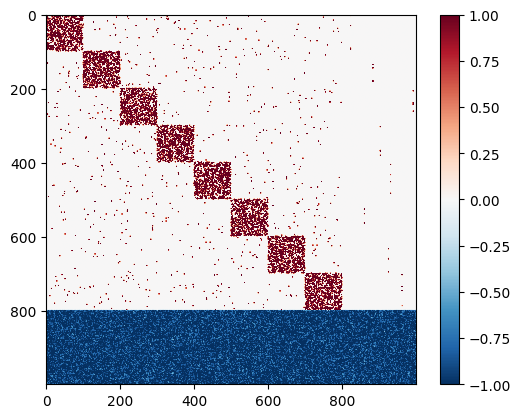

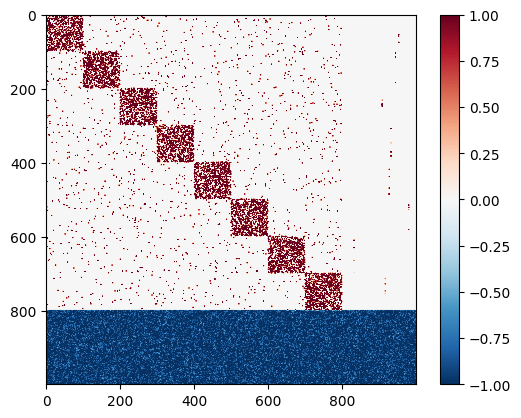

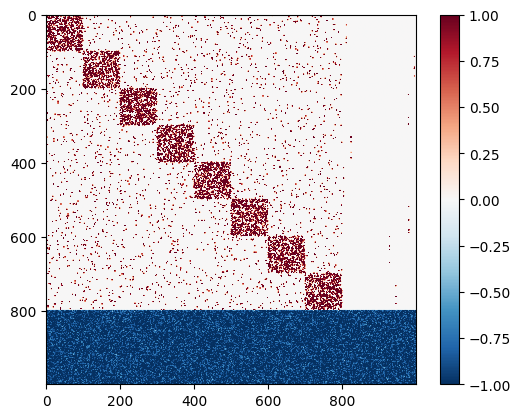

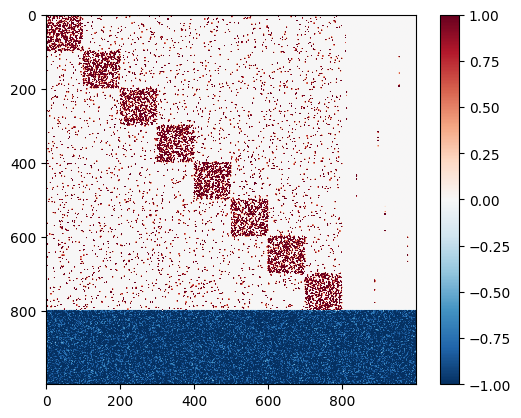

In [9]:
def show_connectivity(network):
  plt.subplots()
  ax = plt.imshow(network._W, cmap="RdBu_r", vmin=-1, vmax=1)
  plt.colorbar(ax)
  plt.show()

ps = np.arange(0.1, 0.5, step=0.1)
for p in ps:
    n = setup_network(p)
    show_connectivity(n)

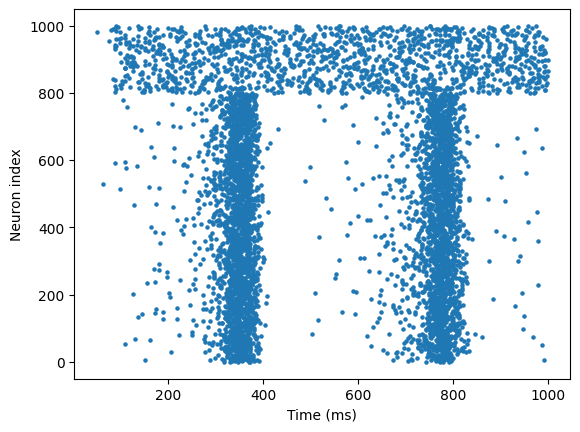

In [ ]:
# Generate raster plot of neuron firing in 1000ms run
T = 1000
network = setup_network(0.875)
V = runNetwork(network, 1000)
t, n = np.where(V > 29)
plt.scatter(t, n, s = 5)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()